In [1]:
from cutils.data_builder.load import load_demographics, load_labtests, load_diagnoses, load_pharma
from cutils.general.data_descriptions import get_kod_bdika_dicts, get_ICD_dicts, get_pharma_dicts, get_makat_to_ATC_dict
from Sandbox.iris.T2D_validation_yochai.config import *
import numpy as np
from datetime import datetime, timedelta
import numpy as np
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay,PrecisionRecallDisplay
import os
import sys
import pandas as pd
from sklearn.metrics import PrecisionRecallDisplay,RocCurveDisplay, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score

%matplotlib inline

In [88]:
comp_new=False
low_a1c_threshold=4
high_a1c_threshold=5.7
recruitment_years = [2006, 2011]
use_plasma_glucose=False
min_num_test=3
n_visits_start=1
n_visits_end=2
calc_stats=False
suffix="Healthy"
recalc_robust_pids=True
curr_fold_name="y_"+str(int(recruitment_years[0]))+"_"+str(int(recruitment_years[1]))+"_mt_"+str(int(min_num_test))+"_mse_"+str(int(n_visits_start))+"_"+str(int(n_visits_end))+suffix
FOLDER=os.path.join("/data1/yochai_t2d/",curr_fold_name)
if not os.path.isdir(FOLDER):
    os.makedirs(FOLDER)

In [89]:
FOLDER

'/data1/yochai_t2d/y_2006_2011_mt_3_mse_1_2Healthy'

In [ ]:
'/data1/yochai_t2d/y_2006_2011_mt_3_mse_1_2_fr'

In [3]:
cat_to_kod_bdika, kod_bdika_to_cat, cat_code_bdika_to_short_desc, cat_code_to_bdika_long_desc,kod_bdika_to_short_desc, kod_bdika_to_long_desc = get_kod_bdika_dicts(load_dir=DATA_FOLDER)
labtests = load_labtests(load_dir=DATA_FOLDER)

ToDo - 
-Check if the robustness test helps or degrades (otherwise, dont limit number of HbA1c tests)
-Check if diagnosys by non-fasting Glucose helps
-Check if limiting the Diabetes cases to only 30days or more after the test helps.

# Statistics

In [4]:
if calc_stats:
    hba1c_cat_code = list(
        {cat:desc for cat, desc in cat_code_to_bdika_long_desc.items() if str(desc).upper() == 'HEMOGLOBIN A1C %'}.keys())[0]
    labtests = load_labtests(load_dir=DATA_FOLDER)
    nunique_labtests=labtests.pid.nunique()
    hba1c_tests = labtests[labtests.bdika_cat_code.eq(hba1c_cat_code)]
    hba1c_tests_all_nunique=hba1c_tests.pid.nunique()
    hba1c_tests = hba1c_tests[hba1c_tests.value.between(3, 16)]
    hba1c_tests_3_16_nunique=hba1c_tests.pid.nunique()
    hba1c_tests = hba1c_tests[hba1c_tests['datetime_bdika'].dt.year.between(*recruitment_years)].compute()
    hba1c_tests_3_16_recruitment_years_nunique=hba1c_tests.pid.nunique()
    hba1c_tests_3_16_nunique=hba1c_tests_3_16_nunique.compute()
    rel_sorted_hba1c=pd.read_csv(os.path.join(FOLDER,"rel_sorted_hba1c.csv"))
    cohort_hba1c=pd.read_csv(os.path.join(FOLDER,"cohort_hba1c.csv"),index_col=["pid"])
    robust_sorted_hba1c_single_test_df=pd.read_csv(os.path.join(FOLDER,"robust_sorted_hba1c_single_test_df.csv"),
                                                           index_col=["pid","datetime_bdika"])

# Functions

In [5]:
def calc_rel_sorted_hba1c(min_num_test=4,batch_size=250,recruitment_years=recruitment_years):
    """Return df of participants with more than min_num_test"""
    hba1c_cat_code = list(
    {cat:desc for cat, desc in cat_code_to_bdika_long_desc.items() if str(desc).upper() == 'HEMOGLOBIN A1C %'}.keys())[0]
    labtests = load_labtests(load_dir=DATA_FOLDER)
    hba1c_tests = labtests[labtests.bdika_cat_code.eq(hba1c_cat_code)]
    hba1c_tests = hba1c_tests[hba1c_tests.value.between(3, 16)]
    hba1c_tests = hba1c_tests[hba1c_tests['datetime_bdika'].dt.year.between(*recruitment_years)].compute()
    hba1c_tests.to_csv(os.path.join(FOLDER,"hba1c_tests.csv"))
    sorted_hba1c=hba1c_tests.set_index(['pid','datetime_bdika']).sort_index()
    sorted_df=sorted_hba1c.reset_index()
    rel_pid=sorted_df.groupby("pid").count()>=min_num_test
    rel_pid=rel_pid.loc[rel_pid["test"]==True,:].index.values
    rel_pid_ind=[x for x in rel_pid if x!=0]
    range(int(np.ceil(len(rel_pid_ind)/batch_size)))
    sorted_hba1c_list=[]
    for ind in tqdm(range(int(np.ceil(len(rel_pid_ind)/batch_size)))):
        if (ind+1)*batch_size<len(rel_pid_ind):
            sorted_hba1c_list.append(sorted_hba1c.loc[rel_pid_ind[ind*batch_size:(ind+1)*batch_size],:])
        else:
            sorted_hba1c_list.append(sorted_hba1c.loc[rel_pid_ind[ind*batch_size:],:])
    rel_sorted_hba1c=pd.concat(sorted_hba1c_list)
    rel_sorted_hba1c.to_csv(os.path.join(FOLDER,"rel_sorted_hba1c.csv"))
    return rel_sorted_hba1c

In [6]:
def check_a1c_robustness(patient_df,n_visits_start,n_visits_end):
    """
    res is bolean, thus it is sufficient to sum its values 
    """
    res=patient_df["value"]<6.5
    if res.iloc[:n_visits_start].sum()==n_visits_start:
        return check_first_t2d_date(patient_df,n_visits_end)
    else:
        return False
    
def check_first_t2d_date(patient_df,n_visits_end):
    res=patient_df["value"]>=6.5
    for ind,x in enumerate(res.values):
        if x:
            if ind>=len(res.values)-n_visits_end:
                return False
            elif res.values[ind:ind+n_visits_end].sum()==n_visits_end:
                return True
            else:
                return False
    return True

In [7]:
def filter_multiteste_same_date(df):
    if df["value"].sum()> df.shape[0]:
        return False
    else:
        return True

In [8]:
def get_robust_hba1c_df(min_num_test,n_visits_start=2,n_visits_end=2,recalc_robust_pids=True):
    file_name="robust_sorted_hba1c_"+str(int(n_visits_start))+"_"+str(int(n_visits_end))+"_single_test_df"
    if os.path.isfile(os.path.join(FOLDER,"rel_sorted_hba1c.csv")):
        rel_sorted_hba1c=pd.read_csv(os.path.join(FOLDER,"rel_sorted_hba1c.csv"),index_col="pid")
    else:
        rel_sorted_hba1c=calc_rel_sorted_hba1c(min_num_test=min_num_test,batch_size=250)
                      
    if recalc_robust_pids:
        rubust_pids=rel_sorted_hba1c.reset_index().groupby("pid").apply(check_a1c_robustness,n_visits_start=n_visits_start,n_visits_end=n_visits_end)
        rubust_pids.to_csv(os.path.join(FOLDER,"rubust_pids_"+str(int(n_visits_start))+"_"+str(int(n_visits_end))+"_.csv"),index=True)
    else:
        rubust_pids=pd.read_csv(os.path.join(FOLDER,"rubust_pids_"+str(int(n_visits_start))+"_"+str(int(n_visits_end))+"_.csv"),header=None)
        rubust_pids.columns=["pid","bolean"]
        rubust_pids=rubust_pids.set_index("pid")
    pids_array=rubust_pids.values.flatten()
    rel_pid_index=rubust_pids.loc[rubust_pids.values.flatten()].index
    robust_sorted_hba1c_df=rel_sorted_hba1c.loc[rel_pid_index,:]
    
    tmp = robust_sorted_hba1c_df.groupby(by=["pid","date_bdika", "bdika_cat_code"]).count()
    keep_df=tmp.groupby("pid").apply(filter_multiteste_same_date)
    keep_df_ind=keep_df.loc[keep_df].index
    robust_sorted_hba1c_df=robust_sorted_hba1c_df.loc[keep_df_ind,:]
    robust_sorted_hba1c_df.to_csv(os.path.join(FOLDER,file_name+".csv"),
                                                  index=True)
    return robust_sorted_hba1c_df

In [9]:
def get_first_non_diabetic_test(robust_sorted_hba1c_single_test_df):
    hba1c_tests=robust_sorted_hba1c_single_test_df.reset_index()
    earliest_hba1c_tests = hba1c_tests.sort_values(by='datetime_bdika').groupby('pid').first()
    earliest_hba1c_tests = earliest_hba1c_tests[earliest_hba1c_tests.value.lt(6.5)]
    cohort_hba1c = earliest_hba1c_tests.copy()
    cohort_hba1c.to_csv(os.path.join(FOLDER,"cohort_hba1c.csv"),index=["pid"])
    return cohort_hba1c

# 1. First time point

## a. Earliest HbA1c 6.5% test

In [10]:
if comp_new:
    rel_sorted_hba1c=calc_rel_sorted_hba1c(min_num_test=min_num_test,batch_size=250,recruitment_years=recruitment_years)
else:
    hba1c_tests=pd.read_csv(os.path.join(FOLDER,"hba1c_tests.csv"),index_col=[0])
    rel_sorted_hba1c=pd.read_csv(os.path.join(FOLDER,"rel_sorted_hba1c.csv"),index_col=[0,1])

/data1/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [11]:
comp_earliest=True
if comp_new or comp_earliest:
    robust_sorted_hba1c_single_test_df=get_robust_hba1c_df(min_num_test,n_visits_start=n_visits_start,n_visits_end=n_visits_end,recalc_robust_pids=recalc_robust_pids)    
    cohort_hba1c=get_first_non_diabetic_test(robust_sorted_hba1c_single_test_df)
    robust_sorted_hba1c_single_test_df.to_csv(os.path.join(FOLDER,"robust_sorted_hba1c_single_test_df.csv"),index=["pid","datetime_bdika"])
else:
    file_name="robust_sorted_hba1c_"+str(int(n_visits_start))+"_"+str(int(n_visits_end))+"_single_test_df"
    robust_sorted_hba1c_single_test_df=pd.read_csv(os.path.join(FOLDER,"robust_sorted_hba1c_single_test_df.csv"),
                                                       index_col=["pid","datetime_bdika"])
    cohort_hba1c=pd.read_csv(os.path.join(FOLDER,"cohort_hba1c.csv"),index_col=["pid"])

/data1/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/data1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  # Remove the CWD from sys.path while we load stuff.


## b. Fetch  data

In [12]:
test_diff = [-30, 30]

### Sex

In [13]:
if comp_new:
    dem = load_demographics(pids=cohort_hba1c.index.values, load_dir=DATA_FOLDER, return_dask=False)
    cohort_haba1c_sex = cohort_hba1c.merge(dem[['datetime_leida', 'is_male']], left_index=True, right_index=True, 
                                           how='inner')
    cohort_haba1c_sex.to_csv(os.path.join(FOLDER,"cohort_haba1c_sex.csv"),index=["pid"])
else:
    cohort_haba1c_sex=pd.read_csv(os.path.join(FOLDER,"cohort_haba1c_sex.csv"),index_col=["pid"])


In [14]:
cohort_haba1c_sex.index.nunique()

179421

### GGT

In [15]:
if comp_new:
    ggt_tests = labtests[labtests.bdika_cat_code.isin(
        [k for k, v in cat_code_to_bdika_long_desc.items() if 'GGT' in str(v).upper()])].compute()
    ggt_tests = ggt_tests[ggt_tests.pid.isin(cohort_haba1c_sex.index)]
    ggt_tests = ggt_tests.merge(cohort_haba1c_sex['datetime_bdika'],
                                left_on='pid', right_index=True, suffixes=('_ggt','_hb1ac'), how='inner')
    ggt_tests['datetime_bdika_hb1ac']=pd.to_datetime(ggt_tests['datetime_bdika_hb1ac'])
    ggt_tests['test_time_diff'] = (ggt_tests['datetime_bdika_hb1ac'] - ggt_tests['datetime_bdika_ggt']).dt.days
    ggt_tests = ggt_tests[ggt_tests['test_time_diff'].between(*test_diff)]
    ggt_tests = ggt_tests.loc[ggt_tests['test_time_diff'].abs().sort_values().index].groupby('pid').first()
    ggt_tests.to_csv(os.path.join(FOLDER,"ggt_tests.csv"))
    cohort_haba1c_sex_ggt = cohort_haba1c_sex.merge(ggt_tests.rename(columns={'value':'GGT'})['GGT'], left_index=True, right_index=True, how='outer')
    cohort_haba1c_sex_ggt.to_csv(os.path.join(FOLDER,"cohort_haba1c_sex_ggt.csv"),index=["pid"])
else:
    ggt_tests=pd.read_csv(os.path.join(FOLDER,"ggt_tests.csv"),index_col="pid")
    cohort_haba1c_sex_ggt=pd.read_csv(os.path.join(FOLDER,"cohort_haba1c_sex_ggt.csv"),index_col=["pid"])

In [16]:
cohort_haba1c_sex_ggt.index.nunique()

179421

## Reticulocyte count

In [17]:
if comp_new:
    reticulocyte_counts = labtests[labtests.bdika_cat_code.isin(
        [k for k, v in cat_code_to_bdika_long_desc.items() if 'RETICUL. COUNT abs' in str(v)])].compute()
    reticulocyte_counts = reticulocyte_counts[reticulocyte_counts.value.notnull()]
    reticulocyte_counts = reticulocyte_counts[reticulocyte_counts.pid.isin(cohort_haba1c_sex_ggt.index)]
    reticulocyte_counts = reticulocyte_counts.merge(
    cohort_haba1c_sex_ggt['datetime_bdika'], left_on='pid', right_index=True, suffixes=('_reticulocyte','_hb1ac'), how='inner')
    reticulocyte_counts['datetime_bdika_hb1ac']=pd.to_datetime(reticulocyte_counts['datetime_bdika_hb1ac'])
    reticulocyte_counts['datetime_bdika_reticulocyte']=pd.to_datetime(reticulocyte_counts['datetime_bdika_reticulocyte'])
    reticulocyte_counts['test_time_diff'] = (
    reticulocyte_counts['datetime_bdika_hb1ac'] - reticulocyte_counts['datetime_bdika_reticulocyte']).dt.days
    reticulocyte_counts = reticulocyte_counts[reticulocyte_counts['test_time_diff'].between(*test_diff)]
    reticulocyte_counts = reticulocyte_counts.loc[
        reticulocyte_counts['test_time_diff'].abs().sort_values().index].groupby('pid').first()
    reticulocyte_counts.to_csv(os.path.join(FOLDER,"reticulocyte_counts.csv"),index=True)
    cohort_haba1c_sex_ggt_rtc = cohort_haba1c_sex_ggt.merge(reticulocyte_counts.rename(
    columns={'value':'Reticulocyte Count'})['Reticulocyte Count'],
                      left_index=True, 
                      right_index=True,
                      how='outer')
    cohort_haba1c_sex_ggt_rtc.to_csv(os.path.join(FOLDER,"cohort_haba1c_sex_ggt_rtc.csv"),index=["pid"])
else:
    reticulocyte_counts=pd.read_csv(os.path.join(FOLDER,"reticulocyte_counts.csv"),index_col=[0])
    cohort_haba1c_sex_ggt_rtc=pd.read_csv(os.path.join(FOLDER,"cohort_haba1c_sex_ggt_rtc.csv"),index_col=["pid"])

In [18]:
cohort_haba1c_sex_ggt_rtc.notna().sum()

datetime_bdika        179421
date_bdika            179421
value                 179421
kod_gorem_mafne       179421
test                  179421
bdika_cat_code        179421
datetime_leida        179421
is_male               179421
GGT                    80020
Reticulocyte Count       927
dtype: int64

### HDL

In [19]:
if comp_new:
    hdl_tests = labtests[labtests.bdika_cat_code.isin(
        [k for k, v in cat_code_to_bdika_long_desc.items() if 'CHOLESTEROL- HDL'==str(v)])].compute()
    hdl_tests = hdl_tests[hdl_tests.pid.isin(cohort_haba1c_sex_ggt_rtc.index)]
    hdl_tests = hdl_tests.merge(cohort_haba1c_sex_ggt_rtc['datetime_bdika'], left_on='pid', right_index=True, suffixes=('_hdl','_hb1ac'), 
                                how='inner')
    hdl_tests['datetime_bdika_hb1ac']=pd.to_datetime(hdl_tests['datetime_bdika_hb1ac'])
    hdl_tests['datetime_bdika_hdl']=pd.to_datetime(hdl_tests['datetime_bdika_hdl'])
    hdl_tests['test_time_diff'] = (hdl_tests['datetime_bdika_hb1ac'] - hdl_tests['datetime_bdika_hdl']).dt.days
    hdl_tests = hdl_tests[hdl_tests['test_time_diff'].between(*test_diff)]
    hdl_tests = hdl_tests.loc[hdl_tests['test_time_diff'].abs().sort_values().index].groupby('pid').first()
    hdl_tests.to_csv(os.path.join(FOLDER,"hdl_tests.csv"),index=["pid"])
    cohort_haba1c_sex_ggt_rtc_hdl = cohort_haba1c_sex_ggt_rtc.merge(hdl_tests.rename(
        columns={'value':'HDL'})['HDL'],
                          left_index=True, 
                          right_index=True,
                          how='outer')
    cohort_haba1c_sex_ggt_rtc_hdl.to_csv(os.path.join(FOLDER,"cohort_haba1c_sex_ggt_rtc_hdl.csv"),index=["pid"])
else:
    hdl_tests=pd.read_csv(os.path.join(FOLDER,"hdl_tests.csv"),index_col=["pid"])
    cohort_haba1c_sex_ggt_rtc_hdl=pd.read_csv(os.path.join(FOLDER,"cohort_haba1c_sex_ggt_rtc_hdl.csv"),index_col=["pid"])

In [20]:
cohort_haba1c_sex_ggt_rtc_hdl.notna().sum()

datetime_bdika        179421
date_bdika            179421
value                 179421
kod_gorem_mafne       179421
test                  179421
bdika_cat_code        179421
datetime_leida        179421
is_male               179421
GGT                    80020
Reticulocyte Count       927
HDL                   151969
dtype: int64

### Triglycerides

In [21]:
if comp_new:
    triglycerides_tests = labtests[labtests.bdika_cat_code.isin(
        [k for k, v in cat_code_to_bdika_long_desc.items() if 'TRIGLYCERIDES'==str(v)])].compute()
    triglycerides_tests = triglycerides_tests[triglycerides_tests.pid.isin(cohort_haba1c_sex_ggt_rtc_hdl.index)]
    triglycerides_tests = triglycerides_tests.merge(cohort_haba1c_sex_ggt_rtc_hdl['datetime_bdika'], 
                                                    left_on='pid', 
                                                    right_index=True, 
                                                    suffixes=('_triglycerides','_hb1ac'), how='inner')
    triglycerides_tests['datetime_bdika_hb1ac']=pd.to_datetime(triglycerides_tests['datetime_bdika_hb1ac'])
    triglycerides_tests['datetime_bdika_triglycerides']=pd.to_datetime(triglycerides_tests['datetime_bdika_triglycerides'])
    triglycerides_tests['test_time_diff'] = (
        triglycerides_tests['datetime_bdika_hb1ac'] - triglycerides_tests['datetime_bdika_triglycerides']).dt.days
    triglycerides_tests = triglycerides_tests[triglycerides_tests['test_time_diff'].between(*test_diff)]
    triglycerides_tests = triglycerides_tests.loc[
        triglycerides_tests['test_time_diff'].abs().sort_values().index].groupby('pid').first()
    triglycerides_tests.to_csv(os.path.join(FOLDER,"triglycerides_tests.csv"),index=["pid"])
    cohort_haba1c_sex_ggt_rtc_hdl_tgl = cohort_haba1c_sex_ggt_rtc_hdl.merge(triglycerides_tests.rename(
        columns={'value':'Triglycerides'})['Triglycerides'],
                          left_index=True, 
                          right_index=True,
                          how='outer')
    cohort_haba1c_sex_ggt_rtc_hdl_tgl.index.rename("pid",inplace=True)
    cohort_haba1c_sex_ggt_rtc_hdl_tgl.to_csv(os.path.join(FOLDER,"cohort_haba1c_sex_ggt_rtc_hdl_tgl.csv"),index=["pid"])
else:
    triglycerides_tests=pd.read_csv(os.path.join(FOLDER,"triglycerides_tests.csv"),index_col=["pid"])
    cohort_haba1c_sex_ggt_rtc_hdl_tgl=pd.read_csv(os.path.join(FOLDER,"cohort_haba1c_sex_ggt_rtc_hdl_tgl.csv"),index_col=["pid"])

### How many are filtered for each null value

In [22]:
cohort=cohort_haba1c_sex_ggt_rtc_hdl_tgl.copy()

In [23]:
cohort.index.nunique()

179421

## Filter ages

In [1]:
cohort = cohort[cohort[['GGT', 'HDL', 'Triglycerides',"value"]].notnull().all(axis=1)].copy()
cohort['Age'] = (pd.to_datetime(cohort['datetime_bdika']) - pd.to_datetime(cohort['datetime_leida'])).dt.days.div(365.25)
cohort = cohort[cohort['Age'].between(40, 70)].copy()

NameError: name 'cohort' is not defined

In [25]:
cohort.shape

(43020, 13)

In [26]:
bt_df=cohort.loc[:,["value","is_male","GGT","Reticulocyte Count","HDL","Triglycerides"]].copy()
bt_df_no_retic=cohort.loc[:,["value","is_male","GGT","HDL","Triglycerides"]].copy()
bt_df_nona=bt_df.dropna(how="any",axis=0)
bt_df_no_retic=bt_df_no_retic.dropna(how="any")

## C. No diabetes diagnosis of diabetes related drugs

We need to filter out unstable participants, based on their HbA1c values, diagnosys, fasting and remove participants who are getting Glucomin.
Similar to how I filtered the participants above.

### Hab1c > 6.5

In [28]:
# hba1c_tests = labtests[labtests.bdika_cat_code.eq(hba1c_cat_code)]
hba1c_first_diagnosed = robust_sorted_hba1c_single_test_df[robust_sorted_hba1c_single_test_df.value.gt(6.5)].reset_index().sort_values(by='datetime_bdika').groupby('pid').first()
hba1c_first_diagnosed.datetime_bdika=pd.to_datetime( hba1c_first_diagnosed.datetime_bdika)
hba1c_first_diagnosed = hba1c_first_diagnosed.datetime_bdika.dt.date.to_frame()
hba1c_first_diagnosed.rename(columns={'datetime_bdika': 'first_diabetic_hba1c'}, inplace=True)

### Random plasma glucose

In [30]:
# def check_a1c_robustness(patient_df,n_visits_start,n_visit_end):
#     """
#     res is bolean, thus it is sufficient to sum its values 
#     """
#     res=patient_df["value"]<6.5
#     if res.iloc[:n_visits_start].sum()==n_visits_start:
#         return check_first_t2d_date(patient_df,n_visit_end)
#     else:
#         return False

# def check_first_t2d_date(patient_df,n_visit_end):
#     res=patient_df["value"]>=6.5
#     for ind,x in enumerate(res.values):
#         if x:
#             if ind>=len(res.values)-n_visit_end:
#                 return False
#             elif res.values[ind:ind+n_visit_end].sum()==n_visit_end:
#                 return True
#             else:
#                 return False
#     return True

In [31]:
def check_test_robustness(patient_df,n_visits_start,n_visits_end,t_hold_value=200):
    """
    res is bolean, thus it is sufficient to sum its values 
    """
    res=patient_df["value"]<t_hold_value
    if res.iloc[:n_visits_start].sum()==n_visits_start:
        return check_first_onset_date(patient_df,n_visits_end)
    else:
        return False
    
def check_first_onset_date(patient_df,n_visits_end,t_hold_value=200):
    res=patient_df["value"]>=t_hold_value
    for ind,x in enumerate(res.values):
        if x:
            if ind>=len(res.values)-n_visits_end:
                return False
            elif res.values[ind:ind+n_visits_end].sum()==n_visits_end:
                return True
            else:
                return False
    return True

In [32]:
if use_plasma_glucose:
    if comp_new:
        plasma_glucose_cat_codes = [k for k, v in cat_code_to_bdika_long_desc.items() if ('GLUCOSE' == str(v).upper())]
        plasma_glucose = labtests[labtests.bdika_cat_code.isin(plasma_glucose_cat_codes)]
        plasma_glucose_df=plasma_glucose[plasma_glucose['datetime_bdika'].dt.year.between(*recruitment_years)].compute()
        all_plasma_pids=plasma_glucose_df.index.get_level_values(0)
        rel_gluc_index=[x for x in all_plasma_pids if x in cohort.index]
        rel_plasma_glucose_df=plasma_glucose_df.set_index(['pid','datetime_bdika']).loc[rel_gluc_index,:].sort_index()
        rel_plasma_glucose_df.loc[:,["value","bdika_cat_code"]].to_csv(os.path.join(FOLDER,"rel_plasma_glucose_df.csv"),index=True)
        rel_plasma_glucose_df=rel_plasma_glucose_df.loc[rel_plasma_glucose_df.value.notna(),:]
        rel_plasma_glucose_df=rel_plasma_glucose_df[rel_plasma_glucose_df.value.between(50,600).values]
        rel_plasma_glucose_df.loc[:,["value","bdika_cat_code"]].to_csv(os.path.join(FOLDER,"rel_plasma_glucose_df.csv"),index=True)

        # rel_glucose_gt200_df=rel_plasma_glucose_df.value>200
        diagnosed_by_glucose=rel_plasma_glucose_df.reset_index().groupby("pid").apply(check_first_onset_date,n_visits_end=2,t_hold_value=200)
        first_glucose_diagnosys=pd.to_datetime(
            rel_plasma_glucose_df.loc[diagnosed_by_glucose.values,:].reset_index().groupby("pid").datetime_bdika.min()).to_frame()
        drop_glucose=first_glucose_diagnosys<pd.to_datetime(cohort.loc[first_glucose_diagnosys.index,"datetime_bdika"]).to_frame()
        drop_glucose_index=drop_glucose[drop_glucose.values].index
        first_glucose_diagnosys=first_glucose_diagnosys.drop(drop_glucose_index)
        cohort=cohort.drop(drop_glucose_index)
        first_glucose_diagnosys.to_csv(os.path.join(FOLDER,"first_glucose_diagnosys.csv"),index=True)

    else:
        rel_plasma_glucose_df=pd.read_csv(os.path.join(FOLDER,"rel_plasma_glucose_df.csv"),index_col=['pid','datetime_bdika'])
        first_glucose_diagnosys=pd.read_csv(os.path.join(FOLDER,"first_glucose_diagnosys.csv"),index_col=True)


### Diagnosis

In [33]:
# if comp_new:
diagnoses = load_diagnoses(load_dir=DATA_FOLDER, pids=cohort.index.values, return_dask=False)

[########################################] | 100% Completed |  1min 20.1s


In [35]:
icd9_dicts = {}
_, icd9_dicts['ICD_to_cat'], _, icd9_dicts['ICD_to_desc'] = get_ICD_dicts(load_dir=DATA_FOLDER)
diabetic_diagnosis_icd9_codes = {k: v for k, v in icd9_dicts['ICD_to_desc'].items() if
                                         (('250' in k[:3]) & ('DIABETES' in v) & ('TYPE I,' not in v) & (
                                                 'JUVENILE' not in v))}
diabetes_omit_dict={'250': 'DIABETES MELLITUS',
 '2500': 'DIABETES MELLITUS WITHOUT MENTION OF COMPLICATION',
 '25000': 'ADULT-ONSET TYPE DIABETES MELLITUS WHITHOUT COMPLICATION',
 '2501': 'DIABETES WITH KETOACIDOSIS',
 '2502': 'DIABETES WITH HYPEROSMOLAR COMA',
 '2503': 'DIABETES WITH OTHER COMA',
 '2504': 'DIABETES WITH RENAL MANIFESTATIONS',
 '2505': 'DIABETES WITH OPHTHALMIC MANIFESTATIONS',
 '2506': 'DIABETES WITH NEUROLOGICAL MANIFESTATIONS',
 '2507': 'DIABETES WITH PERIPHERAL CIRCULATORY DISORDERS',
 '2508': 'DIABETES WITH OTHER SPECIFIED MANIFESTATIONS',
 '2509': 'DIABETES WITH UNSPECIFIED COMPLICATION'}
filtered_diabetic_diagnosis_icd9_codes={k:v for k,v in diabetic_diagnosis_icd9_codes.items() if v not in diabetes_omit_dict.values()}
diabetic_diagnoses_cat_codes = [icd9_dicts['ICD_to_cat'][k] for k in
                                        diabetic_diagnosis_icd9_codes.keys()]
diabetic_known_diagnoses_cat_codes = [icd9_dicts['ICD_to_cat'][k] for k in
                                        filtered_diabetic_diagnosis_icd9_codes.keys()]


In [36]:
diabetic_diagnoses = diagnoses[diagnoses['diag_cat_code'].isin(diabetic_diagnoses_cat_codes)]
diabetic_known_diagnoses= diagnoses[diagnoses['diag_cat_code'].isin(diabetic_known_diagnoses_cat_codes)]
diabetic_diagnoses_pid=list(set(diabetic_diagnoses.pid.values))
diabetic_known_diagnoses_pids=list(set(diabetic_known_diagnoses.pid.values))
drop_pids=[x for x in  diabetic_diagnoses_pid if x not in diabetic_known_diagnoses_pids and x in diabetic_diagnoses_pid and x in cohort.index]
drop_pids=list(set(drop_pids))
t2d_diagnoses=diabetic_diagnoses.set_index("pid").drop(drop_pids,axis=0).reset_index()
first_diabetic_diagnosis = t2d_diagnoses.groupby('pid')[['datetime_start', 'datetime_bikur']].min().min(axis=1).dt.date
first_diabetic_diagnosis=pd.to_datetime(first_diabetic_diagnosis)
first_diabetic_diagnosis.name="first_diabetic_diagnosis"
first_diabetic_diagnosis.head()
cohort=cohort.drop(drop_pids)

### Drugs

In [37]:
if comp_new:
    cat_to_makat_parit, makat_parit_to_cat, cat_to_desc, makat_parit_to_desc = get_pharma_dicts(load_dir=DATA_FOLDER)
    makat_to_ATC_level_3 = get_makat_to_ATC_dict(level=3)
    prescriptions = load_pharma(load_dir=DATA_FOLDER, extended_data=True, pids=cohort.index.values, return_dask=False)
    diabetes_drugs_cat_codes = [makat_parit_to_cat[makat] for makat, ATC in makat_to_ATC_level_3.items() if ATC.upper() in ["A10A","A10B","A10X"]]
    prescriptions = prescriptions[prescriptions.makat_parit_cat_code.isin(diabetes_drugs_cat_codes)]
    first_diabetes_prescription = prescriptions.groupby('pid')['datetime_nipuk'].min().dt.date
    first_diabetes_prescription=pd.to_datetime(first_diabetes_prescription)
    first_diabetes_prescription.to_csv(os.path.join(FOLDER,"first_diabetes_prescription.csv"),index=["pid"])
else:
    first_diabetes_prescription=pd.read_csv(os.path.join(FOLDER,"first_diabetes_prescription.csv"),header=None)
    first_diabetes_prescription.columns=["pid","datetime_nipuk"]
    first_diabetes_prescription=first_diabetes_prescription.set_index("pid")

### Join origins of diabetes

In [38]:
use_a1c_as_diagnosys=True
if use_a1c_as_diagnosys:
    if use_plasma_glucose:
        diabetes_start_date = pd.concat([first_diabetic_diagnosis, hba1c_first_diagnosed,first_glucose_diagnosys], 
                                        axis=1)
        diabetes_start_date.columns = ['first_diagnosis', 'first_hba1c',"first_plasma_glucose"]
    else:
        diabetes_start_date = pd.concat([first_diabetic_diagnosis, hba1c_first_diagnosed], 
                                        axis=1)
        diabetes_start_date.columns = ['first_diagnosis', 'first_hba1c']
    diabetes_start_date['diabetes_date'] = diabetes_start_date.apply(lambda row: min(row[pd.notnull(row)]), axis=1)
else:
    diabetes_start_date=first_diabetic_diagnosis.copy()
    diabetes_start_date.rename(columns={'first_diagnosis':'diabetes_date'},inplace=True)
diabetes_start_date=pd.concat([diabetes_start_date,first_diabetes_prescription],axis=1)
diabetes_start_date["datetime_nipuk"]=pd.to_datetime(diabetes_start_date["datetime_nipuk"])
diabetes_start_date["diabetes_date"]=pd.to_datetime(diabetes_start_date["diabetes_date"])
non_diabetic_indexes=list(set(diabetes_start_date[diabetes_start_date["diabetes_date"].isna()].index.values))
prescribed_indexes=list(set(diabetes_start_date[diabetes_start_date["datetime_nipuk"].notna()].index.values))
drop_early_nipuk_non_diagnosed=list(
    set([x for x in non_diabetic_indexes if x in prescribed_indexes]))
drop_early_nipuk_non_diagnosed.extend(
    list(set(diabetes_start_date[diabetes_start_date["datetime_nipuk"]<diabetes_start_date["diabetes_date"]].index.values)))
drop_early_nipuk_non_diagnosed=list(set(drop_early_nipuk_non_diagnosed))
drop_indexes=drop_early_nipuk_non_diagnosed
drop_indexes=[x for x in drop_indexes if x in cohort.index]
cohort=cohort.drop(drop_indexes)
cohort=cohort.loc[cohort.datetime_bdika.notnull()].copy()
diabetes_no_early_nipuk=diabetes_start_date.drop(drop_indexes)
cohort=cohort.merge(diabetes_no_early_nipuk["diabetes_date"],left_index=True,right_index=True,how="left")
cohort['datetime_bdika'] = pd.to_datetime(cohort['datetime_bdika'])
# cohort['date_bdika']=pd.to_datetime(cohort['date_bdika'])

# Calculate Non diagnosed with Prescreption

In [39]:
non_diab_index=cohort[cohort.diabetes_date.isna()].index
non_diab_with_precription_dict={x:first_diabetes_prescription.loc[x] for x in non_diab_index if x in first_diabetes_prescription.index}
non_diab_with_precription_dict

{}

In [40]:
cohort.loc[:,"diabetes_date"].notna().sum()/cohort.shape[0]

0.09756232075887933

In [41]:
tmp_cohort=cohort[(cohort['diabetes_date'] - cohort['datetime_bdika']).dt.days.fillna(np.inf).ge(1)]

In [42]:
cohort = cohort[(cohort['diabetes_date'] - cohort['datetime_bdika']).dt.days.fillna(np.inf).ge(30)]

In [43]:
cohort["diabetes_date"].notna().sum()/cohort.shape[0]

0.044886761615689934

### Cohort add hemoglobin levels

In [45]:
# hemoglobin_cats = {k: v for k, v in cat_code_to_bdika_long_desc.items() if ('HB' == str(v).upper())}
# hemoglobin_tests = labtests[labtests.bdika_cat_code.isin(hemoglobin_cats.keys())]
# hemoglobin_tests = hemoglobin_tests[hemoglobin_tests.value.notnull()]
# hemoglobin_tests = hemoglobin_tests[hemoglobin_tests.pid.isin(cohort.index.values)]
# hemoglobin_tests = hemoglobin_tests.compute()



# hemoglobin_tests = hemoglobin_tests.merge(cohort['datetime_bdika'], 
#                                                 left_on='pid', 
#                                                 right_index=True, 
#                                                 suffixes=('_hemoglobin','_hb1ac'), how='inner')
# hemoglobin_tests.shape[0]

# hemoglobin_tests['test_time_diff'] = (
#     hemoglobin_tests['datetime_bdika_hb1ac'] - hemoglobin_tests['datetime_bdika_hemoglobin']).dt.days
# hemoglobin_tests.shape[0]

# hemoglobin_tests = hemoglobin_tests[hemoglobin_tests['test_time_diff'].between(*test_diff)]
# hemoglobin_tests.shape[0]

# hemoglobin_tests = hemoglobin_tests.loc[
#     hemoglobin_tests['test_time_diff'].abs().sort_values().index].groupby('pid').first()
# hemoglobin_tests.shape[0]

# print(cohort.shape)
# cohort = cohort.merge(hemoglobin_tests.rename(
#     columns={'value':'HB'})['HB'],
#                       left_index=True, 
#                       right_index=True,
#                       how='outer')
# cohort.shape[0]

### Filter ages

In [46]:
cohort=cohort[cohort["value"]>=low_a1c_threshold]
cohort=cohort[cohort["value"]<high_a1c_threshold]

In [47]:
df = cohort.copy()
df = df[df[['GGT', 'HDL', 'Triglycerides',"value"]].notnull().all(axis=1)].copy()
df['Age'].head()

pid
487     61.084189
1085    66.869268
1823    65.733060
2078    56.607803
2422    56.887064
Name: Age, dtype: float64

In [48]:
cohort.shape

(10064, 14)

<AxesSubplot:>

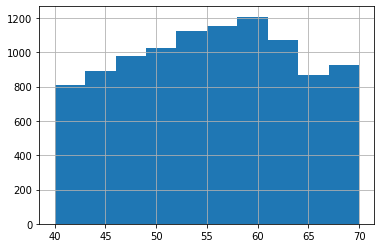

In [49]:
df['Age'].hist()

Continue from here!!!

In [50]:
df.shape

(10064, 14)

### Convert to UKB units

In [51]:
df['UKB_HbA1c'] = (df['value'] - 2.15) * 10.929
df["UKB_HDL"]=df["HDL"]*0.02586
df["UKB_Triglycerides"] = df["Triglycerides"]*0.01129

# Define Scoreboard functions

## Without reticulocytes

### Years for prediction wo Ret

### check sex without reticulocytes

In [52]:
def check_sex(row):
    if row["is_male"]==1:
        return 4
    elif row["is_male"]==0:
        return 0
    else:
        print("is_male should be 0 or 1")

In [53]:
def check_dt(row):
    factor=365.25
    dt=row["delta_time_years"]
    if dt<=5:
        return 0
    elif dt<=6:
        return 10
    elif dt<=8:
        return 11
    elif dt<=9:
        return 14
    elif dt<=10:
        return 17
    elif dt>10:
        return 22
    else:
        print("dt must be a timedelta object")
        return None

### 3. HbA1c %  wo Ret

In [54]:
def check_a1c(row):
#     print(row)
    val=row["UKB_HbA1c"]
    if val<=30.3:
        return 0
    elif val<=31.8:
        return 1
    elif val<=32.9:
        return 9
    elif val<=34.6:
        return 12
    elif val<=35.4:
        return 20
    elif val<=36.3:
        return 24
    elif val<=37.4:
        return 30
    elif val<=39.0:
        return 34
    elif val>39:
        return 54
    else:
        print("a1c is not in any range")
        return None

### 4. HDL  wo Ret

In [55]:
def check_hdl(row):
    val=row["UKB_HDL"]
    if val<=1.1:
        return 29
    elif val<=1.3:
        return 21
    elif val<=1.4:
        return 20
    elif val<=1.5:
        return 16
    elif val<=1.6:
        return 13
    elif val<=1.9:
        return 9 
    elif val>1.9:
        return 0
    else:
        print("HDL is not in any range")
        return None

### 5. Gamma glutamyltransferase  wo Ret

In [56]:
def check_ggt(row):
    val=row["GGT"]
    if val<=14.8:
        return 0
    elif val<=18:
        return 14
    elif val<=21.3:
        return 19
    elif val<=25.2:
        return 21
    elif val<=30.3:
        return 24
    elif val<=37.6:
        return 29
    elif val<=53.1:
        return 32
    elif val>53.1:
        return 34
    else:
        print("GGT is not in any range")
        return None

### 7. Triglycerides  wo Ret

In [57]:
def check_triglycerides(row):
    val=row["UKB_Triglycerides"]
    if val<=0.89:
        return 0
    elif val<=1.2:
        return 5
    elif val<=1.4:
        return 6
    elif val<=1.8:
        return 8
    elif val<=2.4:
        return 11
    elif val>2.4:
        return 14
    else:
        print("triglycerides is not in any range")
        return None

### 8. Age

In [58]:
def check_age(row):
    val=row["Age at returning visit"]
    if val<=57:
        return 4
    elif val<=64:
        return 2
    elif val<=69:
        return 1
    elif val>69:
        return 0
    else:
        print("Age is not in any range")
        return None

In [59]:
("UKB_Triglycerides","GGT","UKB_HDL","UKB_HbA1c","delta_time_years")

('UKB_Triglycerides', 'GGT', 'UKB_HDL', 'UKB_HbA1c', 'delta_time_years')

### 8. calc_score  wo Ret

In [60]:
def calc_basic_score(df):
    colName='basic_score'
    df[colName]=0
    df[colName] += df.apply(check_sex,axis=1)
    df[colName] += df.apply(check_a1c, axis=1)
    df[colName] += df.apply(check_hdl, axis=1)
    df[colName] += df.apply(check_ggt, axis=1)
    df[colName] += df.apply(check_triglycerides, axis=1)
    return df

In [61]:
def add_dt_to_score(df,ind=0):
    colName='score_'+str(int(ind))
    df[colName]=df["basic_score"]+df.apply(check_dt,axis=1)
    df[colName] += df.apply(check_age, axis=1)
    return df[colName].values

## With reticulocytes

# Calc score without reticulocytes

In [62]:
cohort.value.min()

4.0

In [63]:
cohort.value.max()

5.6999998089999995

<AxesSubplot:>

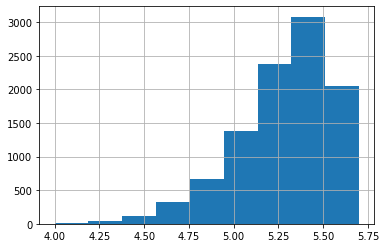

In [64]:
cohort.value.hist(bins=9)

<AxesSubplot:>

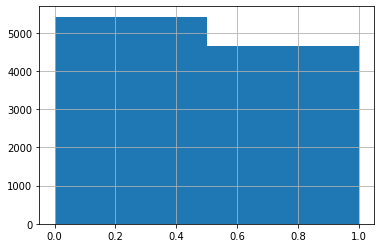

In [65]:
cohort.is_male.hist(bins=2)

In [67]:
tmp_is_diabetic=cohort

In [68]:
cohort["diabetes_date"].notna().sum()/cohort["diabetes_date"].shape[0]

0.023748012718600955

In [86]:
cohort.describe()

,date_bdika,value,kod_gorem_mafne,bdika_cat_code,is_male,GGT,Reticulocyte Count,HDL,Triglycerides,Age
count,10064.000000,10064.000000,1.006400e+04,10064.0,10064.000000,10064.000000,45.000000,10064.000000,10064.000000,10064.000000
mean,2837.845489,5.298592,2.054772e+06,1094.0,0.461645,31.506518,58.879889,49.404581,138.990690,55.293247
std,446.130898,0.283151,4.988497e+06,0.0,0.498552,49.988430,33.447963,13.231556,79.988708,8.254259
min,2192.000000,4.000000,7.010300e+04,1094.0,0.000000,1.000000,0.000000,10.000000,16.000000,40.000000
25%,2469.750000,5.100000,7.052140e+05,1094.0,0.000000,16.000000,43.100000,40.000000,88.000000,48.481862
50%,2773.000000,5.390000,7.057760e+05,1094.0,0.000000,22.000000,59.799999,47.000000,121.000000,55.498973
75%,3126.000000,5.500000,7.086740e+05,1094.0,1.000000,32.000000,84.600000,56.000000,168.000000,61.905544
max,4333.000000,5.700000,7.999816e+07,1094.0,1.000000,2824.000000,146.000000,144.000000,1519.000000,69.990418


In [87]:
cohort.describe().to_csv(os.path.join(to_clalit_folder,"Healthy_describe.csv"),index=True)

In [2]:
n_cycles=1000
sample_time=True
results_folder=os.path.join(FOLDER,"final_results")
comp_new=True
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)
plt.style.use("dark_background")
def my_relative_delta(row):
    return pd.to_datetime(row["datetime_bdika"]).replace(year=row["datetime_bdika"].year + row["dt_years"])
mean_dt=7.3
sigma=2.3
max_dt=17
min_dt=2
df=calc_basic_score(df)
if comp_new:
#     if sample_time:
    df_st=df.copy()
    for ind in tqdm(range(n_cycles)):
        if ind%100==0:
            print(ind)
        np.random.seed(ind)
        df_st["dt_years"]=np.clip(np.random.normal(mean_dt, sigma, size=df_st.shape[0],),a_max=max_dt,a_min=min_dt)
        df_st['date_second_visit'] = (pd.to_datetime(
            df_st['datetime_bdika']) + pd.to_timedelta(
            df_st['dt_years']*365.25, unit='D')).clip(upper=datetime.strptime("2019-12-31", "%Y-%m-%d")).dt.date
        df_st["diabetes_date"]=pd.to_datetime(df_st["diabetes_date"])
        df_st["date_second_visit"]=pd.to_datetime(df_st["date_second_visit"])
        df_st['is_diabetic'] = df_st.apply(
            lambda row: False if pd.isnull(row['diabetes_date']) else 
            row['diabetes_date']<=row['date_second_visit'], axis=1).astype(int)
        df_st['delta_time_years'] = (df_st['date_second_visit'] - df_st['datetime_bdika']).dt.days.div(365.25)
        df_st["Age at returning visit"]=df_st["Age"]+df_st['delta_time_years']
        df_st['score_'+str(int(ind))] = 0
        df_st["score_"+str(int(ind))]=add_dt_to_score(
            df_st.loc[:,["basic_score","Age at returning visit",'delta_time_years']],ind=ind)

    df_st.to_csv(os.path.join(results_folder,"scores_df_st.csv"),index=["pid"])
    df_f=df_st.copy()
else:
    df_f=pd.read_csv(os.path.join(results_folder,"scores_df_st.csv"),index_col=["pid"])



NameError: name 'os' is not defined

In [72]:
df_f=pd.read_csv(os.path.join(results_folder,"scores_df_st.csv"),index_col=["pid"])

In [73]:
df_f.columns[0:30]

Index(['datetime_bdika', 'date_bdika', 'value', 'kod_gorem_mafne', 'test',
       'bdika_cat_code', 'datetime_leida', 'is_male', 'GGT',
       'Reticulocyte Count', 'HDL', 'Triglycerides', 'Age', 'diabetes_date',
       'UKB_HbA1c', 'UKB_HDL', 'UKB_Triglycerides', 'basic_score', 'dt_years',
       'date_second_visit', 'is_diabetic', 'delta_time_years',
       'Age at returning visit', 'score_0', 'score_1', 'score_2', 'score_3',
       'score_4', 'score_5', 'score_6'],
      dtype='object')

In [74]:
df_f.columns[0:20]

Index(['datetime_bdika', 'date_bdika', 'value', 'kod_gorem_mafne', 'test',
       'bdika_cat_code', 'datetime_leida', 'is_male', 'GGT',
       'Reticulocyte Count', 'HDL', 'Triglycerides', 'Age', 'diabetes_date',
       'UKB_HbA1c', 'UKB_HDL', 'UKB_Triglycerides', 'basic_score', 'dt_years',
       'date_second_visit'],
      dtype='object')

In [75]:
comp_new=True
if comp_new:
    auroc_list=[]
    aps_list=[]
    for ind in range(n_cycles):
        aps_list.append(average_precision_score(df_f["is_diabetic"].values,df_f["score_"+str(int(ind))].values))
        auroc_list.append(roc_auc_score(df_f["is_diabetic"].values,df_f["score_"+str(int(ind))].values))
    aps_mean=np.mean(aps_list)
    aps_quant=np.quantile(aps_list,q=[0.025,0.975])
    auroc_mean=np.mean(auroc_list)
    auroc_quant=np.quantile(auroc_list,q=[0.025,0.975])
    aps_ci_str="["+"{:.2f}".format(aps_quant[0])+","+"{:.2f}".format(aps_quant[1])+"]"
    auroc_ci_str="["+"{:.2f}".format(auroc_quant[0])+","+"{:.2f}".format(auroc_quant[1])+"]"

    results_df=pd.DataFrame(index=["aps_mean","aps_CI","auROC mean","auROC_CI"],columns=["results"],data=[aps_mean,aps_ci_str,auroc_mean,auroc_ci_str])
    results_df.to_csv(os.path.join(results_folder,"ROC_APS_CI.csv"),index=True)
else:
    results_df=pd.read_csv(os.path.join(results_folder,"ROC_APS_CI.csv"),index_col=0)
results_df.head()

,results
aps_mean,0.0428958
aps_CI,"[0.04,0.05]"
auROC mean,0.676664
auROC_CI,"[0.66,0.69]"


In [84]:
df_f["is_diabetic"].sum()/df_f["is_diabetic"].shape

array([0.02017091])

In [85]:
df_f["is_diabetic"].sum()

203

In [83]:
df_f["is_diabetic"].shape

(10064,)

In [77]:
auroc_quant[0]

0.6646393365314822

In [78]:
auroc_quant[1]

0.6874004200255471

In [79]:
to_clalit_folder="/data1/safe/From_Clalit"
summary_folder_name=os.path.join(to_clalit_folder,curr_fold_name)
rel_cols=['score_'+str(int(x)) for x in range(1000)]
if not os.path.isdir(summary_folder_name):
    os.mkdir(summary_folder_name)
df_f.reset_index().loc[:,rel_cols+['is_diabetic']].to_csv(os.path.join(summary_folder_name,"scores_df.csv"))
results_df.to_csv(os.path.join(summary_folder_name,"real_healthy_ROC_APS_CI.csv"),index=True)

In [80]:
to_clalit_folder="/data1/safe/From_Clalit"
# summary_folder_name=os.path.join(to_clalit_folder,curr_fold_name)
rel_cols=['score_'+str(int(x)) for x in range(1000)]
df_f.reset_index().loc[:,rel_cols+["is_diabetic"]].to_csv(os.path.join(to_clalit_folder,"YochaisNoPriorsT2D_scores_df.csv"))
results_df.to_csv(os.path.join(to_clalit_folder,"real_healthy_T2D_ROC_APS_CI.csv"),index=True)

In [81]:
curr_fold_name

'y_2006_2011_mt_3_mse_1_2Healthy'

In [85]:
!ls /data1/safe/From_Clalit/y_2006_2011_mt_3_mse_1_2_fr

real_pre_diab_ROC_APS_CI.csv  ROC_APS_CI.csv  scores_df.csv


In [86]:
final_df = df_f.copy()
# final_df = final_df[final_df.value.lt(5.7)].copy()
# final_df = final_df[final_df['HB'].between(11, 16)]
# final_df['score'] = final_df['score_with_reticulocytes']
# final_df = final_df[final_df['score'].notnull()]

In [87]:
precision, recall, _ = precision_recall_curve(final_df['is_diabetic'], final_df['score'])
PR_disp=PrecisionRecallDisplay(precision=precision, recall=recall).plot()
_ = PR_disp.ax_.set_title(f"2-class Precision-Recall curve, AP={np.mean(precision):.2f}, Prevalence={final_df['is_diabetic'].mean():.2f}")
plt.tight_layout()
# plt.savefig('/data1/safe/From_Clalit/precision_recall_curve_yochai.png')
plt.show()

KeyError: 'score'

In [ ]:
fpr, tpr, thresholds = roc_curve(final_df['is_diabetic'], final_df['score'])
ROC_disp=RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
_ = ROC_disp.ax_.set_title(f"2-class ROC, AUC={auc(fpr, tpr):.2f}, N={final_df.shape[0]}")
plt.tight_layout()
plt.show()
# plt.savefig('/data1/safe/From_Clalit/roc_yochai.png')

In [ ]:
final_df.reset_index().loc[:,['is_diabetic','score']].to_csv(os.path.join(FOLDER,"scores_df.csv"))

In [ ]:
final_df.drop(
    columns=['kod_gorem_mafne', 'bdika_cat_code',
             'delta_time_years', 'UKB_HbA1c', 'HDL', 'Reticulocyte Count', 'Triglycerides']).rename(columns={
    'value':'HbA1c%', 
    'UKB_HDL': 'HDL', 
    'UKB_reticulocyte_count': 'Reticulocyte Count', 
    'is_diabetic': 'Outcome', 'UKB_Triglycerides': 'Triglycerides'}).describe().T.loc[[
    'is_male', 'Age', 'HbA1c%', 'GGT', 'HB', 'dt_years', 'score', 
    'HDL', 'Triglycerides', 'Reticulocyte Count', 'Outcome']].round(2).style
#to_csv('/data1/safe/From_Clalit/summary_stats_yochai.csv')

# Downsample prevalence

In [ ]:
diab_prev=0.0217

In [ ]:
def downSamplePrevalence(df):
    df

In [ ]:
df_diabetic=df.loc[df.loc[:,"is_diabetic"]==1,:]
df_non_diabetic=df.loc[df.loc[:,"is_diabetic"]==0,:]

In [ ]:
df_diabetic.sort_values(by="score").tail(10)

In [ ]:
df_non_diabetic.sort_values(by="score").tail(10)

In [ ]:
diab_count=int(diab_prev*df.shape[0])
non_diab_count=int((1-diab_prev)*df.shape[0])
print("diab_count:",diab_count)
print("non_diab_count:",non_diab_count)


In [ ]:
1-diab_prev

In [ ]:
df_non_diab_sample=df_non_diabetic.sample(n=non_diab_count,replace=True)
df_non_diab_sample.head()

In [ ]:
df_non_diab_sample.shape

In [ ]:
df_non_diab_sample["is_diabetic"].sum()

In [ ]:
df_diab_sample=df_diabetic.sample(n=diab_count)
df_diab_sample.head()

In [ ]:
df_diab_sample.shape

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(12,6))
df_non_diab_sample["score"].hist(ax=axs[0])
df_diab_sample["score"].hist(ax=axs[1])
plt.show()

In [ ]:
mut_df=pd.concat([df_diab_sample,df_non_diab_sample])
mut_df

In [ ]:
precision, recall, _ = precision_recall_curve(mut_df['is_diabetic'], mut_df['score'])
PR_disp=PrecisionRecallDisplay(precision=precision, recall=recall).plot()
_ = PR_disp.ax_.set_title(f"2-class Precision-Recall curve, AP={np.mean(precision):.2f}, Prevalence={mut_df['is_diabetic'].mean():.2f}")
plt.tight_layout()
# plt.savefig('/data1/safe/From_Clalit/precision_recall_curve_yochai.png')
plt.show()

In [ ]:
mut_df['is_diabetic'].mean()

In [ ]:
fpr, tpr, thresholds = roc_curve(mut_df['is_diabetic'], mut_df['score'])
ROC_disp=RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
_ = ROC_disp.ax_.set_title(f"2-class ROC, AUC={auc(fpr, tpr):.2f}, N={mut_df.shape[0]}")
plt.tight_layout()
plt.show()